# Zanim przystąpimy do ćwiczenia
W tym ćwiczeniu skorzystamy z modułu sklearn (scikit-learn) przeznaczonego do uczenia maszynowego. Zawiera wiele zoptymalizowanych i przydatnych funkcji i algorytmów. Alternatywnymi frameworkami są np. PyTorch, Tensorflow, Keras, Caffe2, chociaż z obserwacji środowiska wynika, że dominują raczej PyTorch i Tensorflow.


In [1]:
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

Zainstalowana wersja scikit-learn: 0.20.3.


Na stronie przedmiotu znajduje się instrukcja konfiguracji środowiska w przypadku pracy lokalnej, a nie w colabie. Może (nie musi) być przydatna dla osób pracujących na własnych laptopach:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/konfiguracja

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # aby wykresy w Colabie były większe

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Ćwiczenie: Walidacja krzyżowa
Już na ostatnich ćwiczeniach przerobiliśmy walidację krzyżową. Teraz przyjrzymy się jej bliżej i sprawdźmy efekt wspomniany na wykładzie, czyli efekt częstości występowania.

* W tym ćwiczeniu przyjrzymy się jak miary jakości klasyfikatora zależą od proporcji klas w zbiorze uczącym i od rozmiaru zbioru uczącego
* Klasyfikatorem będzie nadal regresja logistyczna, ale tym razem zamiast korzystać z własnej implementacji, skorzystamy z gotowej wersji bibliotecznej z modułu [scikit-learn] (http://scikit-learn.org/stable/index.html)


Dzisiaj znowu wygenerujemy sztucznie dane, które później będziemy klasyfikować, a to po to, aby mieć pełną kontrolę nad częstością występowania klas.

Poniższa funkcja przyjmuje za argument liczbę przykładów, którą ma wygenerować.
Wygenerowane przykłady będą pochodziły z dwóch dwuwymiarowych rozkładów normalnych = klas określonych przez średnią mu[klasa] i macierz kowariancji cov[klasa]. Możemy te cechy dowolnie zmieniać.

In [3]:
def gen(ile):
    a=1
    mu = [(-a,-a),(a,a)] #średnie klas
    cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
    
    X = np.zeros((ile*len(mu), 2)) # miejsce na dane wejściowe
    Y = np.zeros((ile*len(mu), 1),dtype = int) # miejsce na dane wyjściowe
    for klasa in range(len(mu)):
        X[klasa*ile:(klasa+1)*ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
        Y[klasa*ile:(klasa+1)*ile] = klasa
    Y = Y.ravel()
    return (X,Y)

Testujemy tę funkcję, generujemy 50 przykładów, pierwszych 5 wypisujemy, wszystkie rysujemy za pomocą funkcji `scatter`. Pamiętajmy, że za każdym wywołaniem funkcji będziemy dostawać różne dane (jako że są one generowane przez np.random).

X:  [[-0.33019827  0.93785338]
 [-0.88785746  0.73334469]
 [-0.97266819  0.63314125]
 [-0.23149641 -1.2110792 ]
 [ 0.70981179  1.27489083]]
Y:  [0 0 0 0 0]


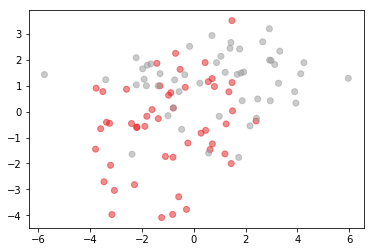

In [4]:
X,Y = gen(50)
print('X: ', X[0:5,:])
print('Y: ', Y[0:5])
plt.scatter(X[:,0], X[:,1], c = Y, cmap=plt.cm.Set1, alpha = 0.5)
plt.show()

# Klasy równoliczne

## Zaobserwujmy zmienność miar jakości klasyfikatora przy wybieraniu podzbiorów do uczenia i testowania ze zbioru uczącego.
* do podziałów zbioru zastosujemy funkcję [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* do obliczania miar jakości zastosujemy funkcje z modułu [sklearn.metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

Wykonaj podział zbioru uczącego tak, aby zestaw testowy stanowił 20% całego zbioru uczącego. Zilustruj za pomocą `scatter` punkty należące do części uczącej i do części testowej.

W razie wątpliwości, sprawdź funkcję w dokumentacji. Warto to robić dla wszelkich problemów, funkcje i metody z bibliotek ML są zazwyczaj dobrze opisane.

* Podział:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = int(0.2*len(Y)))
int(0.2*len(Y))

20

* Ilustracja:

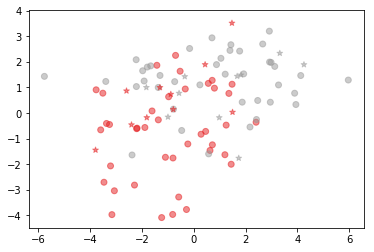

In [6]:
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, cmap=plt.cm.Set1, alpha = 0.5)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test, cmap=plt.cm.Set1, alpha = 0.5, marker = '*' )
plt.show()

Regresja logistyczna zaimplementowana jest w klasie [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Tworzymy instancję obiektu tej klasy. Jeśli nie ustawimy żadnego algorytmu optymalizacji, to domyślnie zostanie ustawiony solver 'lbfgs', ale jednocześnie generuje to irytujący warning, więc lepiej zadeklarować go z góry.

In [7]:
model = LogisticRegression(solver = 'lbfgs')

Uczymy go  na zbiorze uczącym:

In [8]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Wykonujemy predykcje dla zbioru testowego:

In [9]:
y_pred = model.predict(X_test)  

Efekty można obejrzeć za pomocą macierzy pomyłek: 

In [10]:
print(metrics.confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )

[[5 5]
 [3 7]]
TN:  5 FP:  5 FN:  3 TP:  7


W pętli powtórzymy proces podziału zbioru uczącego i dla każdego podziału obliczmy miary jakości:
* precyzja pozytywna: (positive predictive value (PPV), precision). Odpowiada na pytanie: "Jeśli wynik testu jest pozytywny, jakie jest prawdopodobieństwo, że osoba badana jest chora?"

$\qquad$ $PPV = \frac{TP}{P'}=\frac{TP}{ TP + FP}$

* czułość: Prawdopodobieństwo, że klasyfikacja będzie poprawna pod warunkiem, że przypadek jest pozytywny (ang. True Positive Rate, Recall). Jest to np. prawdopodobieństwo, że test wykonany dla osoby chorej wykaże, że jest ona chora.

$\qquad$ $TPR = \frac{TP}{ P} = \frac{TP} { TP+FN}$


* dokładność (accuracy (ACC)): Prawdopodobieństwo prawidłowej klasyfikacji.

$\qquad$ $ACC = \frac{TP + TN}{P + N}$

* F1-score: średnia harmoniczna z precyzji i czułości:

$\qquad$ $F_1= 2 \frac{PPV  \cdot TPR}{PPV+TPR}= \frac{2TP}{ 2TP+FP+FN}$
Miara ta daje ocenę balansu między czułością a precyzją. Miara ta nie uwzględnia wyników prawdziwie negatywnych.

* współczynnik korelacji Matthews ( Matthews correlation coefficient):

$\qquad$ $
\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } }
$

  * Ten współczynnik uwzględnia wyniki zarówno prawdziwie jaki i fałszywie pozytywne i negatywne i jest na ogół uważany jako zrównoważona miara, która może być stosowana nawet wtedy, gdy klasy są bardzo różnej liczebności. 
  * MCC jest w istocie współczynnikiem korelacji pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi; zwraca wartość od -1 do +1. 
    * Współczynnik +1 odpowiada idealnej klasyfikacji, 
    * 0 nie lepiej niż losowe przypisanie wyniku i 
    * -1 oznacza całkowitą niezgodę między klasyfikacją  i stanem faktycznym.

In [11]:
model = LogisticRegression(solver = 'lbfgs') # stwórz instancję klasyfikatora
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = int(0.2*len(Y))) # podziel zbiór z 20% do testowania


    model.fit(X_train, y_train) # naucz klasyfikator
    y_pred = model.predict(X_test)  # wykonaj predykcję dla zbioru testowego
  
    
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

PPV = 0.583 REC = 0.778 ACC = 0.650 F1 = 0.667 MCC =  0.328  
PPV = 0.667 REC = 0.727 ACC = 0.650 F1 = 0.696 MCC =  0.287  
PPV = 0.692 REC = 0.818 ACC = 0.700 F1 = 0.750 MCC =  0.390  
PPV = 0.833 REC = 0.909 ACC = 0.850 F1 = 0.870 MCC =  0.698  
PPV = 0.545 REC = 0.857 ACC = 0.700 F1 = 0.667 MCC =  0.453  
PPV = 0.600 REC = 0.667 ACC = 0.650 F1 = 0.632 MCC =  0.302  
PPV = 0.900 REC = 0.818 ACC = 0.850 F1 = 0.857 MCC =  0.704  
PPV = 0.889 REC = 0.667 ACC = 0.750 F1 = 0.762 MCC =  0.533  
PPV = 0.500 REC = 0.400 ACC = 0.500 F1 = 0.444 MCC =  0.000  
PPV = 0.625 REC = 0.714 ACC = 0.750 F1 = 0.667 MCC =  0.471  


Widzimy, że miary zmieniają się przy każdym losowaniu.

Najczęściej stosuje się nie takie losowe podziały, ale systematyczny podział `k`-krotny (k-fold cross-validation). Procedura wygląda wówczas następująco:
* Dzielimy zbiór uczący (X i y) na `k` równych części
* Odkładamy 1-szą część jako dane testowe, 
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* Wybieramy 2-gą część jako dane testowe
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* $\vdots$

W bibliotece `sklearn` mamy do tego wygodną funkcję `cross_val_score`:

In [12]:
from sklearn.model_selection import cross_val_score

Zobaczmy jak działa:

In [13]:
ppv = cross_val_score(model, X, Y, cv=10, scoring='precision')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(),ppv.std()))
rec = cross_val_score(model, X, Y, cv=10, scoring='recall')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.77 +/- 0.18
REC = 0.76 +/- 0.15
ACC = 0.74 +/- 0.14
F1 = 0.75 +/- 0.12


Dla kompletu zbadajmy jeszcze krzywą ROC. Tym razem też posłużymy się funkcjami bibliotecznymi.

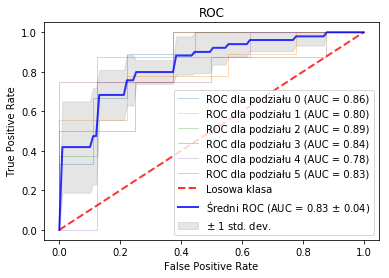

In [14]:
skf  = StratifiedKFold(n_splits=6)
model = LogisticRegression(solver = 'lbfgs')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in skf.split(X, Y):
    model.fit(X[train], Y[train]) # fitujemy regresję
    probas_ = model.predict_proba(X[test])  # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                            # do klas wg. wyuczonego klasyfikatora 
                                            # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw = 2, color='r',
         label = 'Losowa klasa', alpha = 0.8)
      

# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Sprawdźmy jak miary jakości zależą od rozmiaru zbioru uczącego:

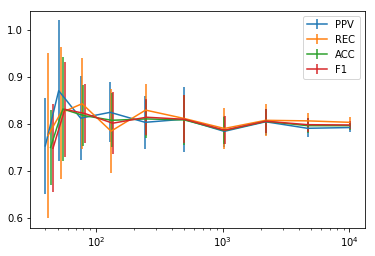

In [15]:
N = 10
PPV_mean = np.zeros((N,1))
PPV_std = np.zeros((N,1))
REC_mean = np.zeros((N,1))
REC_std = np.zeros((N,1))
ACC_mean = np.zeros((N,1))
ACC_std = np.zeros((N,1))
F1_mean = np.zeros((N,1))
F1_std = np.zeros((N,1))

n = 30 + np.floor(np.logspace(1,4,N)).astype(int)

for i in range(N):
    X,Y = gen(int(n[i]))
    model = LogisticRegression(solver = 'lbfgs')
    ppv = cross_val_score(model, X, Y, cv=10, scoring='precision')
    PPV_mean[i] = ppv.mean()
    PPV_std[i]  = ppv.std()
    rec = cross_val_score(model, X, Y, cv=10, scoring='recall')
    REC_mean[i]  = rec.mean()
    REC_std[i]  = rec.std()
    acc = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
    ACC_mean[i]  = acc.mean()
    ACC_std[i]  = acc.std()
    f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
    F1_mean[i]  = f1.mean()
    F1_std[i]  = f1.std()
    
ax = plt.subplot(1,1,1)
plt.errorbar(n, PPV_mean, yerr = PPV_std.ravel())
plt.errorbar(n+2, REC_mean, yerr = REC_std.ravel())
plt.errorbar(n+4, ACC_mean, yerr = ACC_std.ravel())
plt.errorbar(n+6, F1_mean, yerr = F1_std.ravel())
plt.legend(('PPV','REC','ACC','F1'))
ax.set_xscale("log", nonposx='clip')
plt.show()

# Klasy niezrównoważone

Wytwórzymy teraz dane, w których jedna z klas jest M-krotnie liczniejsza. 

In [28]:
def gen_rozne(ile, M):
    a=1.2
    mu = [(-a,-a),(a,a)]
    #mu = [(-1,0.5),(-1,0.5)]
    cov = [diag([1.7,1.8]), diag([1.5,0.7])]
    X = np.zeros(((M+1)*ile, 2)) # miejsce na dane wejściowe
    Y = np.zeros(((M+1)*ile, 1),dtype = int) # miejsce na dane wyjściowe
    print(Y.shape)
    klasa = 0
    X[0:ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
    Y[0:ile] = klasa
    klasa =1 
    X[ile:ile+ile*M] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile*M)
    Y[ile:ile+ile*M] = klasa
    Y = Y.ravel()
    print(np.sum(Y==0), np.sum(Y==1) )
    return (X,Y)

Oglądamy dane:

(3030, 1)
30 3000


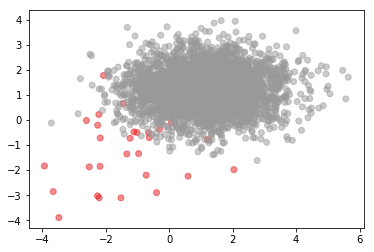

In [29]:
X,Y = gen_rozne(30, 100)
plt.scatter(X[:,0], X[:,1] ,c = Y, cmap=plt.cm.Set1, alpha = 0.5)
plt.show()

Obliczamy miary jakości dla danych niezrównoważonych przy podziale 10-krotnym. Zwróćmy uwagę na różnicę w wartościach 4 pierwszych miar i miary MCC:

In [30]:
model = LogisticRegression(solver = 'lbfgs')
ppv = cross_val_score(model, X, Y, cv=10, scoring='precision')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(),ppv.std()))
rec = cross_val_score(model, X, Y, cv=10, scoring='recall')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))
print('-----')
MCC=np.zeros((10,1))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = int(0.1*len(Y))) # test na 10% aby było podobnie jak dla podziału 10-krotnego
    model.fit(X_train, y_train) # trenuj model
    y_pred = model.predict(X_test)  # predykcja dla zbioru testowego
    MCC[i] = metrics.matthews_corrcoef(y_test, y_pred)
print('MCC = {0:.2f} +/- {1:.2f}'.format(MCC.mean(),MCC.std()))  
   

PPV = 0.99 +/- 0.00
REC = 1.00 +/- 0.00
ACC = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
-----
MCC = 0.61 +/- 0.33


/home/feigenbaum/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/feigenbaum/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Teraz spróbujemy zobaczyć czy da się to poprawić, jeśli w podziałach zadbać o zachowanie proporcji klas. Można to łatwo zrobić za pomocą funkcji `StratifiedKFold`, zwraca ona indeksy do zbioru treningowego i testowego:

In [31]:
skf = StratifiedKFold(n_splits = 4)
for train, test in skf.split(X, Y):  
    model.fit(X[train,:],Y[train])
    y_pred = model.predict(X[test,:]) 
    y_test = Y[test]
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

PPV = 0.996 REC = 1.000 ACC = 0.996 F1 = 0.998 MCC =  0.789  
PPV = 0.993 REC = 1.000 ACC = 0.993 F1 = 0.997 MCC =  0.610  
PPV = 0.993 REC = 1.000 ACC = 0.993 F1 = 0.997 MCC =  0.533  
PPV = 0.997 REC = 0.997 ACC = 0.995 F1 = 0.997 MCC =  0.712  


Zbadajmy jeszcze krzywą ROC:

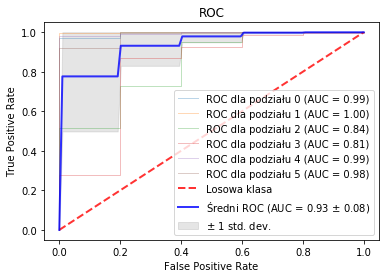

In [25]:
skf  = StratifiedKFold(n_splits=6)
model = LogisticRegression(solver = 'lbfgs')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    model.fit(X[train], Y[train]) # fitujemy regresję
    
    probas_ = model.predict_proba(X[test]) # obliczamy prawdopodobieństwa przynależności przykładów testowych 
                                            # do klas wg. wyuczonego klasyfikatora 
                                            # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # i powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
         
         
# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Powyższe obliczenia obliczenia proszę przeprowadzić dla klas, których rozkłady wyraźnie się różnią i dla takich które się pokrywają w znacznym stopniu. Trzeba podmienić średnie klas w funkcji generującej dane różnoliczne.

# Jakie stąd płyną wnioski?


O czym chciałabym przeczytać w Waszych wnioskach:

1) Jakie płyną konsekwencje z dużej różnicy częstości występowania dwóch klas?

2) Które miary jakości są na ten efekt najmniej i najbardziej wrażliwe?

3) Jak można przeciwdziałać efektowi częstości występowania?

4) Jak miary jakości zależą od rozmiaru zbioru uczącego?

5) Czy efekt częstości występowania ma taki sam czy różny wpływ na miary jakości w przypadku, gdy klasy pochodzą z rozkładów, które się znacząco pokrywają lub są mocno rozseparowane?

Wnioski:

1) Gdy różnica występowania klas jest duża to  miary jakości PPV, REC, ACC, F1 ulegają "sztucznemu" zawyżeniu/poprawieniu. Miara MCC ulega pogoruszeniu/obniżeniu (nawet do zera) co oznacza korelacje pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi nie lepsze niż losowe przypisanie wyniku.

2) Miary PPV, REC, ACC, F1 są bardzo wrażliwe. Miara MCC w małym stopniu.

3) Należy zadbać o zachowanie proporcji klas np. za pomocą funkcji StratifiedKFold.

4) Miary ulegają fluktuacjom dla bardzo małych i małych rozmiarów zbioru - gdy zbiór jest bardzo mały to miary są złe. Potem ulegają stabilizacji i zwiększanie rozmiaru zbioru ich istotnie nie polepsza.

5) Nie. Efekt częstości występowania ma szczególny wpływ gdy klasy pochodzą od rozkładów, które się znacząco pokrywają. W tym przypadku dla dużych różnic w częstości występowania MCC jest bardzo niskie ~0. Sytuacja poprawia się po zachowaniu proporcji klas. Gdy klasy pochodzą od mocno rozseparowanych rozkładów to wszystkie miary jakości są dość duże i zachowanie proporcji klas nie ma większego wpływu na miary jakości.

    